In [1]:
using CSV
using DataFrames
using Plots
using Statistics
using StatsPlots
using Random

In [347]:
"""

Project Goal:

1) Predict the probability that a horse wins in a given race
2) Predict what the final win dividends will be for a horse in a given race

Then, use our predictions to maximize the expected value of betting on races to earn a profit

"""

"\nProject Goal:\n\n1) Predict the probability that a horse wins in a given race\n2) Predict what the final win dividends will be for a horse in a given race\n\nThen, use our predictions to maximize the expected value of betting on races to earn a profit\n\n"

# Exploratory Data Analysis

In [348]:
# Load in our data
races = CSV.read("races.csv")
runs = CSV.read("runs.csv")

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country
,Int64,Int64,Int64,Int64,Float64,Float64,Int64,String?
1,0,1,3917,10,0.0,8.0,3,AUS
2,0,2,2157,8,0.0,5.75,3,NZ
3,0,3,858,7,0.0,4.75,3,NZ
4,0,4,1853,9,0.0,6.25,3,SAF
5,0,5,2796,6,0.0,3.75,3,GB
6,0,6,3296,3,0.0,1.25,3,NZ
7,0,7,911,12,0.0,9.5,3,NZ
8,0,8,2170,1,1.0,0.0,3,AUS
9,0,9,1730,13,0.0,9.75,3,NZ


In [349]:
print(size(runs), size(races))

(79447, 37)(6349, 37)

In [350]:
function summary_stats(arr)
    clean_arr = skipmissing(arr)
    print("missing: $(mean(ismissing.(arr)))%\n")
    print("maximum: $(maximum(clean_arr))\n")
    print("minimum: $(minimum(clean_arr))\n")
    print("median:  $(median(clean_arr))\n")
    print("mean:    $(mean(clean_arr))\n")
    print("std:     $(std(clean_arr))\n")
end

summary_stats (generic function with 1 method)

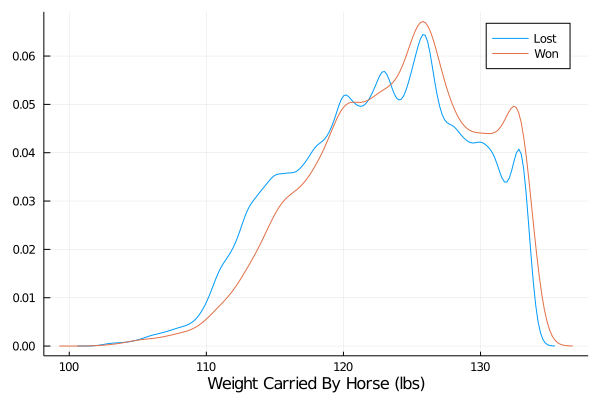

In [351]:
density(runs[:actual_weight], group=runs[:won], labels= ["Lost" "Won"])
xlabel!("Weight Carried By Horse (lbs)")

In [352]:
temp_hist = by(runs, :horse_type, nrow )
temp_hist

,horse_type,nrow
,String?,Int64
1,Gelding,75503
2,Mare,238
3,Horse,1093
4,Brown,2044
5,Rig,154
6,Colt,305
7,missing,2
8,Roan,48
9,Filly,43


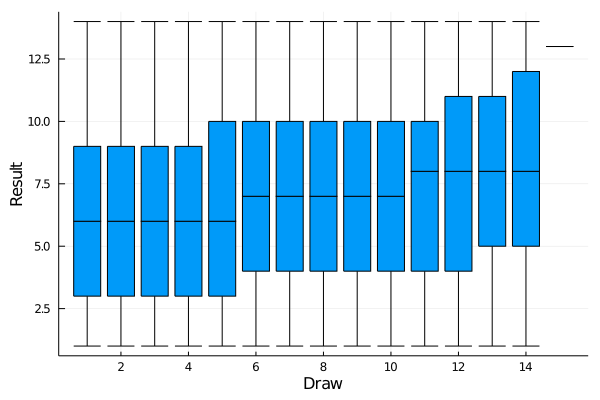

In [353]:
boxplot(runs[:draw], runs[:result], label="")
xlabel!("Draw")
ylabel!("Result")

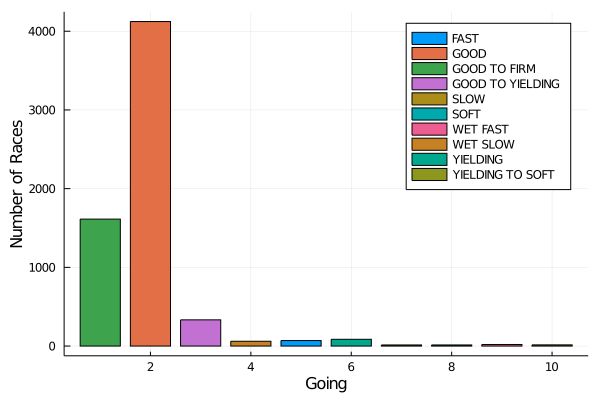

In [354]:
temp_hist = by(races, :going, nrow )
dropmissing!(temp_hist)
bar(temp_hist[:nrow], group=temp_hist[:going])
xlabel!("Going")
ylabel!("Number of Races")

# Preprocessing Data

In [355]:
# Inner join races and runs to get full dataset 
select!(races, Not(:time1))
select!(races, Not(:time2))
select!(races, Not(:time3))
select!(races, Not(:time4))
select!(races, Not(:time5))
select!(races, Not(:time6))
select!(races, Not(:time7))

full_data = innerjoin(races, runs, on =:race_id)

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings
,Int64,Date,String,Int64,String,Int64,Int64,String,String
1,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
2,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
3,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
4,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
5,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
6,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
7,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
8,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
9,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15


In [356]:
# Getting the column names in our dataset that have at least one missing entry 

cols_missing = colwise(x -> any(ismissing.(x)), full_data)
cols_with_missing = []
for i=1:66
    if cols_missing[i] > 0
        append!(cols_with_missing, i)
    end
end

names_list = names(full_data)
col_names_missing =[]
for i in cols_with_missing
    push!(col_names_missing, String(names_list[i]))
end

print(x for x in col_names_missing)

Base.Generator{Array{Any,1},typeof(identity)}(identity, Any["prize", "sec_time4", "sec_time5", "sec_time6", "sec_time7", "place_combination3", "place_combination4", "place_dividend3", "place_dividend4", "win_combination2", "win_dividend2", "horse_country", "horse_type", "position_sec4", "position_sec5", "position_sec6", "behind_sec4", "behind_sec5", "behind_sec6", "time4", "time5", "time6", "place_odds"])

In [357]:
# Now we need to address these missing values 
# Lets look out percent of missing in each column.

for name in col_names_missing 
    try
        print(name)
        print("\n")
        summary_stats(full_data[name])
        print("\n")
    catch
        print("***************************")
        print("Empty array")
        print("***************************\n")
    end
    
end

prize
missing: 0.07362140798268028%
maximum: 2.5e7
minimum: 485000.0
median:  800000.0
mean:    1.117460528818718e6
std:     1.7347670152607828e6

sec_time4
missing: 0.4181529824914723%
maximum: 28.92
minimum: 21.4
median:  23.76
mean:    23.841666161899663
std:     0.801872692835738

sec_time5
missing: 0.8731355494858207%
maximum: 26.5
minimum: 21.81
median:  23.83
mean:    23.87469887885699
std:     0.7450271642038292

sec_time6
missing: 0.9836872380329025%
maximum: 25.92
minimum: 21.77
median:  24.03
mean:    23.934236111111105
std:     0.6605929498312835

sec_time7
missing: 1.0%
***************************Empty array***************************
place_combination3
missing: 0.001762181076692638%
maximum: 14.0
minimum: 1.0
median:  6.0
mean:    6.583983759315067
std:     3.7615102585466706

place_combination4
missing: 0.9963371807620175%
maximum: 14.0
minimum: 4.0
median:  8.0
mean:    8.391752577319588
std:     2.914494222511631

place_dividend3
missing: 0.001762181076692638%
maximum:

In [358]:
"""
We are removing the following columns from the dataset:

    horse_id
    horse_gear
    race_id

    sec_time1
    sec_time2
    sec_time3
    sec_time4
    sec_time5
    sec_time6
    sec_time7

    time1
    time2
    time3
    time4
    time5
    time6
    
    place_combination1 
    place_combination2
    place_combination3
    place_combination4 

    place_dividend1
    place_dividend2
    place_dividend3
    place_dividend4 

    win_combination1
    win_combination2 
    
    win_dividend2

    place_odds

    position_sec1
    position_sec2
    position_sec3
    position_sec4
    position_sec5
    position_sec6
    
    behind_sec1
    behind_sec2
    behind_sec3
    behind_sec4
    behind_sec5
    behind_sec6

    result
    lengths_behind
    finish_time
    win_odds
"""

select!(full_data, Not(:horse_id))
select!(full_data, Not(:horse_gear))
select!(full_data, Not(:race_id))

select!(full_data, Not(:sec_time1))
select!(full_data, Not(:sec_time2))
select!(full_data, Not(:sec_time3))
select!(full_data, Not(:sec_time4))
select!(full_data, Not(:sec_time5))
select!(full_data, Not(:sec_time6))
select!(full_data, Not(:sec_time7))

select!(full_data, Not(:time1))
select!(full_data, Not(:time2))
select!(full_data, Not(:time3))
select!(full_data, Not(:time4))
select!(full_data, Not(:time5))
select!(full_data, Not(:time6))
                            
select!(full_data, Not(:place_combination1))
select!(full_data, Not(:place_combination2))
select!(full_data, Not(:place_combination3))
select!(full_data, Not(:place_combination4))

select!(full_data, Not(:place_dividend1))
select!(full_data, Not(:place_dividend2))
select!(full_data, Not(:place_dividend3))
select!(full_data, Not(:place_dividend4))

select!(full_data, Not(:win_combination1))   
select!(full_data, Not(:win_combination2))

select!(full_data, Not(:win_dividend2))

select!(full_data, Not(:place_odds))

select!(full_data, Not(:position_sec1))
select!(full_data, Not(:position_sec2))
select!(full_data, Not(:position_sec3))
select!(full_data, Not(:position_sec4))
select!(full_data, Not(:position_sec5))
select!(full_data, Not(:position_sec6))

select!(full_data, Not(:behind_sec1))
select!(full_data, Not(:behind_sec2))
select!(full_data, Not(:behind_sec3))
select!(full_data, Not(:behind_sec4))
select!(full_data, Not(:behind_sec5))
select!(full_data, Not(:behind_sec6))


select!(full_data, Not(:result))
select!(full_data, Not(:lengths_behind))
select!(full_data, Not(:finish_time))
select!(full_data, Not(:win_odds))

,date,venue,race_no,config,surface,distance,going,horse_ratings
,Date,String,Int64,String,Int64,Int64,String,String
1,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
2,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
3,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
4,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
5,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
6,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
7,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
8,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
9,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15


In [359]:
"""
We are replacing missing values with the column mean for the following columns:
    prize


Deleting the missing rows from these columns: 
    place_dividend3 -> since there are only a handful missing (0.1% missing)
    
    horse_country -> missing extremely few (0.000025%) missing -> 2 rows! 

    horse_type -> same two rows missing as horse_country that will be deleted 

"""

# rip on julia here cause we found a bug 
temp_prize = DataFrame(hcat(full_data[:prize], full_data[:horse_type]))
dropmissing!(temp_prize, :x1)
temp_mean = mean(temp_prize[:x1])

full_data.prize = coalesce.(full_data.prize, temp_mean)


# dropping  missing values from place_dividend3 only a handful of rows
# dropmissing!(full_data, :place_dividend3)
dropmissing!(full_data, :horse_country)

dropmissing!(full_data, :horse_type)



# *****************************
# Possible Julia bug 
# *************************
# replacing missing values with the column mean for prize

#coalesce.(full_data, mean(full_data[:prize]))
# select!(full_data, Not(:prize))
# full_data = hcat(full_data, prize_temp)

,date,venue,race_no,config,surface,distance,going,horse_ratings
,Date,String,Int64,String,Int64,Int64,String,String
1,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
2,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
3,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
4,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
5,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
6,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
7,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
8,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
9,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15


In [360]:
"""
For our date column we will convert the Date object to a day of the year (int) to account for seasonality.
"""

using Dates
N = 79445
dayofyear = []
for i=1:N
    append!(dayofyear, Dates.dayofyear(full_data[i, :date]))
end

full_data = hcat(dayofyear, full_data)
select!(full_data, Not(:date))

,x1,venue,race_no,config,surface,distance,going,horse_ratings,prize
,Any,String,Int64,String,Int64,Int64,String,String,Float64
1,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
2,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
3,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
4,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
5,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
6,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
7,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
8,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
9,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0


In [361]:
"""
For categorical features we will be doing one-hot encoding over many hot encoding because we do not have any sets.

"""
one_hot_labels = [
  :horse_type,
  :horse_country,
  :config,
  :venue,
  :going, 
  :horse_ratings,
  :jockey_id,
  :trainer_id
]

#Sets of all categories in a particular column
uniq_sets = [unique(full_data[:, label]) for label in one_hot_labels]


"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    result = zeros(length(column), length(cats))
 
    for r in 1:length(column)
        for c in 1:length(cats)
            
            if column[r] == cats[c] 
                result[r, c] = 1
            
            end
        end
    end
   
    result
end


onehot

In [362]:
htype = onehot(full_data[:, :horse_type], uniq_sets[1])
hcountry = onehot(full_data[:, :horse_country], uniq_sets[2])
config = onehot(full_data[:, :config], uniq_sets[3])
venue = onehot(full_data[:, :venue], uniq_sets[4])
going = onehot(full_data[:, :going], uniq_sets[5])
horse_ratings = onehot(full_data[:, :horse_ratings], uniq_sets[6])
jockey_id = onehot(full_data[:, :jockey_id], uniq_sets[7])
trainer_id = onehot(full_data[:, :trainer_id], uniq_sets[8])

one_hots = hcat(htype, hcountry, config, venue, going, horse_ratings, jockey_id, trainer_id)

79445×436 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [363]:
select!(full_data, Not(:horse_type))
select!(full_data, Not(:horse_country))
select!(full_data, Not(:venue))
select!(full_data, Not(:config))
select!(full_data, Not(:going))
select!(full_data, Not(:horse_ratings))
select!(full_data, Not(:jockey_id))
select!(full_data, Not(:trainer_id))

,x1,race_no,surface,distance,prize,race_class,win_dividend1,horse_no
,Any,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,121.0,1
2,153,1,0,1400,485000.0,5,121.0,2
3,153,1,0,1400,485000.0,5,121.0,3
4,153,1,0,1400,485000.0,5,121.0,4
5,153,1,0,1400,485000.0,5,121.0,5
6,153,1,0,1400,485000.0,5,121.0,6
7,153,1,0,1400,485000.0,5,121.0,7
8,153,1,0,1400,485000.0,5,121.0,8
9,153,1,0,1400,485000.0,5,121.0,9


In [364]:
final_full_data = hcat(full_data, DataFrame(one_hots), makeunique=true)

,x1,race_no,surface,distance,prize,race_class,win_dividend1,horse_no
,Any,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,121.0,1
2,153,1,0,1400,485000.0,5,121.0,2
3,153,1,0,1400,485000.0,5,121.0,3
4,153,1,0,1400,485000.0,5,121.0,4
5,153,1,0,1400,485000.0,5,121.0,5
6,153,1,0,1400,485000.0,5,121.0,6
7,153,1,0,1400,485000.0,5,121.0,7
8,153,1,0,1400,485000.0,5,121.0,8
9,153,1,0,1400,485000.0,5,121.0,9


In [365]:
"""
We will remove outliers where there is a very high (750+) win dividend, which we believe only consitutes a very
high-profile race, making up a very small percentage of examples (<1%) in our dataset.
"""

final_full_data = final_full_data[(final_full_data.win_dividend1 .<= 750),:]

,x1,race_no,surface,distance,prize,race_class,win_dividend1,horse_no
,Any,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,121.0,1
2,153,1,0,1400,485000.0,5,121.0,2
3,153,1,0,1400,485000.0,5,121.0,3
4,153,1,0,1400,485000.0,5,121.0,4
5,153,1,0,1400,485000.0,5,121.0,5
6,153,1,0,1400,485000.0,5,121.0,6
7,153,1,0,1400,485000.0,5,121.0,7
8,153,1,0,1400,485000.0,5,121.0,8
9,153,1,0,1400,485000.0,5,121.0,9


# Model Selection (Win Probability)
We will next fit different models to our data to predict win probability. Since there is no way for us to know the true win probability of a given horse winning specific race, we will evaluate the different models and compare them based on their Brier Score, which evaluates the accuracy of probabilistic predictions. The Brier score is calculated by the mean squared error between the predicted probability of an event and the actual outcome of an event occuring (0 or 1). Since we have an unbalanced dataset (mostly losing outcome (0) examples), we will calculate a balanced error rate of the Brier score, which will equally weigh the winning and losing outcomes.

In [366]:
win_prob_full_data = copy(final_full_data)
select!(win_prob_full_data, Not(:win_dividend1))

,x1,race_no,surface,distance,prize,race_class,horse_no,won,horse_age
,Any,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,1,0.0,3
2,153,1,0,1400,485000.0,5,2,0.0,3
3,153,1,0,1400,485000.0,5,3,0.0,3
4,153,1,0,1400,485000.0,5,4,0.0,3
5,153,1,0,1400,485000.0,5,5,0.0,3
6,153,1,0,1400,485000.0,5,6,0.0,3
7,153,1,0,1400,485000.0,5,7,0.0,3
8,153,1,0,1400,485000.0,5,8,1.0,3
9,153,1,0,1400,485000.0,5,9,0.0,3


In [367]:
using Pkg
Pkg.add("ScikitLearn")

  Resolving package versions...
No Changes to `C:\Users\Warren\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Warren\.julia\environments\v1.5\Manifest.toml`


In [368]:
using ScikitLearn
@sk_import linear_model: Ridge
@sk_import linear_model: LogisticRegression

PyObject <class 'sklearn.linear_model._logistic.LogisticRegression'>

In [369]:
function MSE(y, pred)
    #Equivalent to Brier score with two classes
    mse = []
    for (y, y_hat) in zip(y, pred)
        append!(mse, (y - y_hat)^2)
    end
    sum_mse = sum(mse)/length(mse)
end

MSE (generic function with 1 method)

In [370]:
function balanced_brier_score(y, pred)
    win_scores = []
    lose_scores = []
    for (y, y_hat) in zip(y, pred)
        if (y==1.0)
            append!(win_scores, (y - y_hat)^2)
        else
            append!(lose_scores, (y - y_hat)^2)
        end
    end
    score = 0.5*(sum(win_scores)/length(win_scores)) + 0.5*(sum(lose_scores)/length(lose_scores))
end

balanced_brier_score (generic function with 1 method)

In [371]:

"""
We start by isolating our y vector and splitting our dataset into train and test sets.

"""

# Shuffling the dataset out of order 
win_prob_full_data = win_prob_full_data[shuffle(1:end), :]

train_proportion = 0.8
n = size(win_prob_full_data, 1)


println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = win_prob_full_data[:won]
X = convert(Matrix, select!(win_prob_full_data, Not(:won)))
for i=1:89
     X[:, i] = [convert(Float64, X[k, i]) for k=1:78901]
end
X = convert(Array{Float64}, X)

train_x = X[1:ntrain, :]
test_x = X[ntrain+1:end, :]
train_y = target[1:ntrain, :]
test_y = target[ntrain+1:end, :]


train_x = hcat(train_x, ones(ntrain))
test_x = hcat(test_x, ones(n-ntrain))

train_y = [convert(Float64, train_y[i]) for i=1:size(train_y,1)]
test_y = [convert(Float64, test_y[i]) for i=1:size(test_y,1)]

Size of dataset: 78901


15780-element Array{Float64,1}:
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

# Least Squares Regression Model (Win Probability)

In [372]:
w_ls = train_x\train_y 

train_pred_ls = train_x*w_ls
test_pred_ls = test_x*w_ls

train_MSE = MSE(train_y, train_pred_ls)
test_MSE = MSE(test_y, test_pred_ls)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.07137123490368127
Test MSE 	0.07065659029481682


In [373]:
summary_stats(test_pred_ls)

missing: 0.0%
maximum: 0.5832619857898144
minimum: -0.9647871009735054
median:  0.07203619255039317
mean:    0.07945818694812135
std:     0.050321635255266096


In [374]:
for i=1:length(test_pred_ls)
    if (test_pred_ls[i] < 0)
        test_pred_ls[i] = 0
    elseif (test_pred_ls[i] > 1)
        test_pred_ls[i] = 1
    end
end

In [375]:
summary_stats(test_pred_ls)

missing: 0.0%
maximum: 0.5832619857898144
minimum: 0.0
median:  0.07203619255039317
mean:    0.07988390501966466
std:     0.04883672756715415


In [376]:
train_MSE = MSE(train_y, train_pred_ls)
test_MSE = MSE(test_y, test_pred_ls)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	0.07137123490368127
Test MSE 	0.0705634121211309


In [377]:
balanced_brier_score(test_y, test_pred_ls)

0.4014598824426853

# Ridge Regression Model (Win Probability)

In [378]:
ridge = ScikitLearn.fit!(Ridge(alpha = 0.1), train_x, train_y)

PyObject Ridge(alpha=0.1)

In [379]:
test_pred_ridge = ridge.predict(test_x)
MSE(test_y, test_pred_ridge)

0.07061588477979887

In [380]:
balanced_brier_score(test_y, test_pred_ridge)

0.40156856580936484

In [381]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(estimator=Ridge(), param_grid=Dict(:alpha => 0.5:0.5:5), scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.50874e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.35104e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.40606e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.32138e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.55837e-1

GridSearchCV
  estimator: PyCall.PyObject
  param_grid: Dict{Symbol,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -0.07194180685600937
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((10,))
  best_estimator_: PyCall.PyObject


In [382]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :alpha => 5.0

In [383]:
ridge = ScikitLearn.fit!(Ridge(alpha = 5), train_x, train_y)
test_pred_ridge = ridge.predict(test_x)
MSE(test_y, test_pred_ridge)

0.07045774651809814

In [384]:
summary_stats(test_pred_ridge)

missing: 0.0%
maximum: 0.33343684544125485
minimum: -0.06018760959414654
median:  0.07206117574536773
mean:    0.07951384274557152
std:     0.04817557937878275


In [385]:
for i=1:length(test_pred_ridge)
    if (test_pred_ridge[i] < 0)
        test_pred_ridge[i] = 0
    elseif (test_pred_ridge[i] > 1)
        test_pred_ridge[i] = 1
    end
end

In [386]:
summary_stats(test_pred_ridge)

missing: 0.0%
maximum: 0.33343684544125485
minimum: 0.0
median:  0.07206117574536773
mean:    0.07975408610962433
std:     0.047721860192890916


In [387]:
MSE(test_y, test_pred_ridge)

0.07044563513580969

In [388]:
balanced_brier_score(test_y, test_pred_ridge)

0.40143910096546925

# Logistic Regression Model (Win Probability)

In [389]:
log_reg = ScikitLearn.fit!(LogisticRegression(), train_x, train_y)

PyObject LogisticRegression()

In [390]:
test_pred_logistic = log_reg.predict_proba(test_x)[:,2]
summary_stats(test_pred_logistic)

missing: 0.0%
maximum: 0.12706958209710548
minimum: 0.048003882952116675
median:  0.0807118627003581
mean:    0.08101743444284912
std:     0.009880011164345445


In [391]:
MSE(test_y, test_pred_logistic)

0.07325791555949956

In [392]:
balanced_brier_score(test_y, test_pred_logistic)

0.42660306606949705

# Random Forest Regressor Model (Win Probability)

In [393]:
Pkg.add("DecisionTree")
using DecisionTree

  Resolving package versions...
No Changes to `C:\Users\Warren\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Warren\.julia\environments\v1.5\Manifest.toml`


In [394]:
model = build_forest(train_y, train_x, 3, 16)

Ensemble of Decision Trees
Trees:      16
Avg Leaves: 4463.5
Avg Depth:  88.0625

In [395]:
test_pred_rf = apply_forest(model, test_x)
MSE(test_y, test_pred_rf)

0.07217057228610069

In [396]:
balanced_brier_score(test_y, test_pred_rf)

0.4109491392550278

In [397]:
n_rand_features = [x for x=1:1:30]
n_trees = [x for x=1:1:30]

grid_features = Dict(:n_subfeatures => n_rand_features)
grid_trees = Dict(:n_trees => n_trees)

Dict{Symbol,Array{Int64,1}} with 1 entry:
  :n_trees => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21, 22, 23, 24, 25, 26, 27, 28…

In [398]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_features, 
    scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

GridSearchCV
  estimator: RandomForestRegressor
  param_grid: Dict{Symbol,Array{Int64,1}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -0.07389090721926568
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((30,))
  best_estimator_: RandomForestRegressor


In [399]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :n_subfeatures => 21

In [400]:
gridsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_trees, 
    scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

GridSearchCV
  estimator: RandomForestRegressor
  param_grid: Dict{Symbol,Array{Int64,1}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -0.07246629222282203
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((30,))
  best_estimator_: RandomForestRegressor


In [401]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :n_trees => 30

In [402]:
model = build_forest(train_y, train_x, 21, 30)

Ensemble of Decision Trees
Trees:      30
Avg Leaves: 3779.366666666667
Avg Depth:  60.53333333333333

In [403]:
test_pred_rf = apply_forest(model, test_x)
MSE(test_y, test_pred_rf)

0.07126877317731072

In [404]:
balanced_brier_score(test_y, test_pred_rf)

0.4058990654285472

In [405]:
summary_stats(test_pred_rf)

missing: 0.0%
maximum: 0.4015079365079365
minimum: 0.0
median:  0.07037037037037037
mean:    0.07977558439424721
std:     0.048747824863290115


# Model Visualizations (Win Probability)

In [406]:
# function to calculate win percentage of all horses in input

function win_prob(outcomes)
    try
        return sum(outcomes)/size(outcomes)[1]
    catch e
        return 0
    end 
end

win_prob (generic function with 1 method)

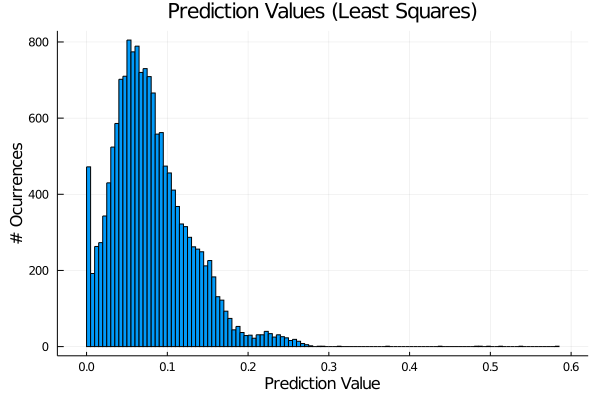

In [407]:
histogram(test_pred_ls, title = "Prediction Values (Least Squares)", label="")
xlabel!("Prediction Value")
ylabel!("# Ocurrences")

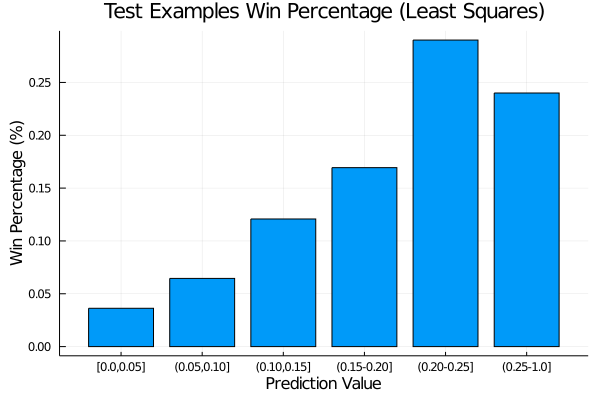

In [408]:
bin05 = []
bin10 = []
bin15 = []
bin20 = []
bin25 = []
bin100 = []

for i=1:length(test_y)
    if (test_pred_ls[i]<=0.05)
        append!(bin05, test_y[i])
    elseif(test_pred_ls[i]<=0.10)
        append!(bin10, test_y[i])
    elseif(test_pred_ls[i]<=0.15)
        append!(bin15, test_y[i])
    elseif(test_pred_ls[i]<=0.20)
        append!(bin20, test_y[i])
    elseif(test_pred_ls[i]<=0.25)
        append!(bin25, test_y[i])
    else
        append!(bin100, test_y[i])
    end
end

win_perc_ls = []
append!(win_perc_ls, win_prob(bin05))
append!(win_perc_ls, win_prob(bin10))
append!(win_perc_ls, win_prob(bin15))
append!(win_perc_ls, win_prob(bin20))
append!(win_perc_ls, win_prob(bin25))
append!(win_perc_ls, win_prob(bin100))

bar(["[0.0,0.05]", "(0.05,0.10]", "(0.10,0.15]", "(0.15-0.20]", "(0.20-0.25]", "(0.25-1.0]"], win_perc_ls, 
    title = "Test Examples Win Percentage (Least Squares)", label = "")
xlabel!("Prediction Value")
ylabel!("Win Percentage (%)")

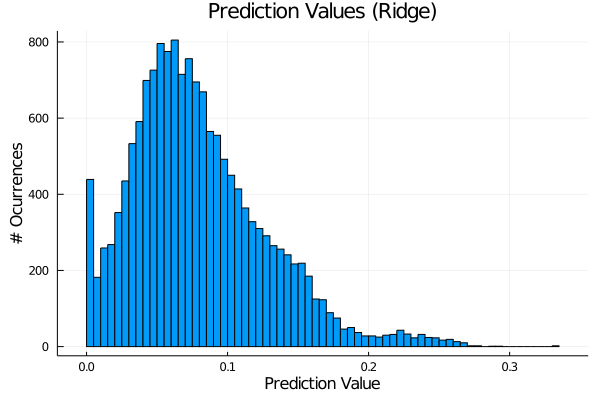

In [409]:
histogram(test_pred_ridge, title = "Prediction Values (Ridge)", label="")
xlabel!("Prediction Value")
ylabel!("# Ocurrences")

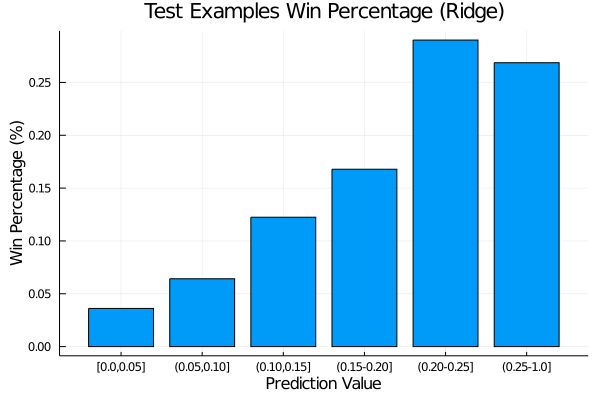

In [410]:
bin05 = []
bin10 = []
bin15 = []
bin20 = []
bin25 = []
bin100 = []

for i=1:length(test_y)
    if (test_pred_ridge[i]<=0.05)
        append!(bin05, test_y[i])
    elseif(test_pred_ridge[i]<=0.10)
        append!(bin10, test_y[i])
    elseif(test_pred_ridge[i]<=0.15)
        append!(bin15, test_y[i])
    elseif(test_pred_ridge[i]<=0.20)
        append!(bin20, test_y[i])
    elseif(test_pred_ridge[i]<=0.25)
        append!(bin25, test_y[i])
    else
        append!(bin100, test_y[i])
    end
end

win_perc_ridge = []
append!(win_perc_ridge, win_prob(bin05))
append!(win_perc_ridge, win_prob(bin10))
append!(win_perc_ridge, win_prob(bin15))
append!(win_perc_ridge, win_prob(bin20))
append!(win_perc_ridge, win_prob(bin25))
append!(win_perc_ridge, win_prob(bin100))

bar(["[0.0,0.05]", "(0.05,0.10]", "(0.10,0.15]", "(0.15-0.20]", "(0.20-0.25]", "(0.25-1.0]"], win_perc_ridge, 
    title = "Test Examples Win Percentage (Ridge)", label = "")
xlabel!("Prediction Value")
ylabel!("Win Percentage (%)")

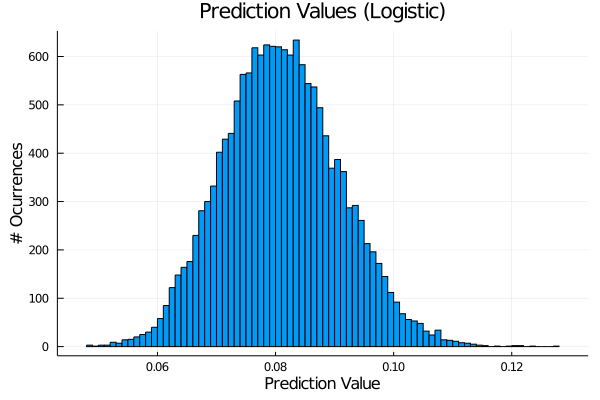

In [411]:
histogram(test_pred_logistic, title = "Prediction Values (Logistic)", label="")
xlabel!("Prediction Value")
ylabel!("# Ocurrences")

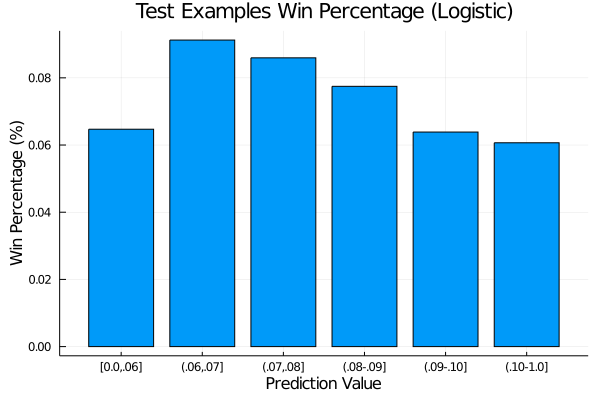

In [412]:
bin06 = []
bin07 = []
bin08 = []
bin09 = []
bin10 = []
bin100 = []

for i=1:length(test_y)
    if (test_pred_logistic[i]<=0.06)
        append!(bin06, test_y[i])
    elseif(test_pred_logistic[i]<=0.07)
        append!(bin07, test_y[i])
    elseif(test_pred_logistic[i]<=0.08)
        append!(bin08, test_y[i])
    elseif(test_pred_logistic[i]<=0.09)
        append!(bin09, test_y[i])
    elseif(test_pred_logistic[i]<=0.10)
        append!(bin10, test_y[i])
    else
        append!(bin100, test_y[i])
    end
end

win_perc_log = []
append!(win_perc_log, win_prob(bin06))
append!(win_perc_log, win_prob(bin07))
append!(win_perc_log, win_prob(bin08))
append!(win_perc_log, win_prob(bin09))
append!(win_perc_log, win_prob(bin10))
append!(win_perc_log, win_prob(bin100))

bar(["[0.0,.06]", "(.06,.07]", "(.07,.08]", "(.08-.09]", "(.09-.10]", "(.10-1.0]"],
    win_perc_log, title = "Test Examples Win Percentage (Logistic)", label = "")
xlabel!("Prediction Value")
ylabel!("Win Percentage (%)")

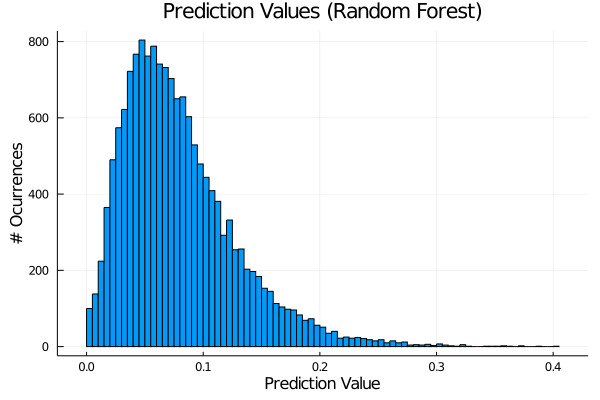

In [413]:
histogram(test_pred_rf, title = "Prediction Values (Random Forest)", label="")
xlabel!("Prediction Value")
ylabel!("# Ocurrences")

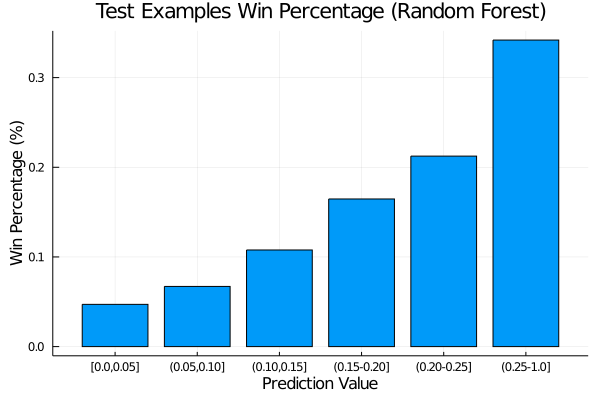

In [414]:
bin05 = []
bin10 = []
bin15 = []
bin20 = []
bin25 = []
bin100 = []

for i=1:length(test_y)
    if (test_pred_rf[i]<=0.05)
        append!(bin05, test_y[i])
    elseif(test_pred_rf[i]<=0.10)
        append!(bin10, test_y[i])
    elseif(test_pred_rf[i]<=0.15)
        append!(bin15, test_y[i])
    elseif(test_pred_rf[i]<=0.20)
        append!(bin20, test_y[i])
    elseif(test_pred_rf[i]<=0.25)
        append!(bin25, test_y[i])
    else
        append!(bin100, test_y[i])
    end
end

win_perc_rf = []
append!(win_perc_rf, win_prob(bin05))
append!(win_perc_rf, win_prob(bin10))
append!(win_perc_rf, win_prob(bin15))
append!(win_perc_rf, win_prob(bin20))
append!(win_perc_rf, win_prob(bin25))
append!(win_perc_rf, win_prob(bin100))

bar(["[0.0,0.05]", "(0.05,0.10]", "(0.10,0.15]", "(0.15-0.20]", "(0.20-0.25]", "(0.25-1.0]"], win_perc_rf, 
    title = "Test Examples Win Percentage (Random Forest)", label = "")
xlabel!("Prediction Value")
ylabel!("Win Percentage (%)")

# Model Selection (Win Dividend)
We will next fit different models to our data to predict the final win dividend of a race. We will compare the performance of different models based on mean square error (MSE).

In [415]:
win_div_full_data = copy(final_full_data)
select!(win_div_full_data, Not(:won))

,x1,race_no,surface,distance,prize,race_class,win_dividend1,horse_no
,Any,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,121.0,1
2,153,1,0,1400,485000.0,5,121.0,2
3,153,1,0,1400,485000.0,5,121.0,3
4,153,1,0,1400,485000.0,5,121.0,4
5,153,1,0,1400,485000.0,5,121.0,5
6,153,1,0,1400,485000.0,5,121.0,6
7,153,1,0,1400,485000.0,5,121.0,7
8,153,1,0,1400,485000.0,5,121.0,8
9,153,1,0,1400,485000.0,5,121.0,9


In [416]:
"""
We start by isolating our y vector and splitting our dataset into train and test sets.

"""

# Shuffling the dataset out of order 
win_div_full_data = win_div_full_data[shuffle(1:end), :]

train_proportion = 0.8
n = size(win_div_full_data, 1)


println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = win_div_full_data[:win_dividend1]
X = convert(Matrix, select!(win_div_full_data, Not(:win_dividend1)))
for i=1:89
     X[:, i] = [convert(Float64, X[k, i]) for k=1:78901]
end
X = convert(Array{Float64}, X)

train_x = X[1:ntrain, :]
test_x = X[ntrain+1:end, :]
train_y = target[1:ntrain, :]
test_y_div = target[ntrain+1:end, :]


train_x = hcat(train_x, ones(ntrain))
test_x = hcat(test_x, ones(n-ntrain))

train_y = [convert(Float64, train_y[i]) for i=1:size(train_y,1)]
test_y_div = [convert(Float64, test_y_div[i]) for i=1:size(test_y_div,1)]

Size of dataset: 78901


15780-element Array{Float64,1}:
  80.0
  28.0
  34.5
  22.0
  64.5
 120.0
  82.5
  68.0
  65.0
  87.0
  78.5
  32.0
 282.0
   ⋮
  86.5
  61.0
 200.0
 377.0
  36.0
  27.5
  74.0
 679.0
  67.5
  40.5
  32.5
 119.5

# Least Squares Regression Model (Win Dividend)

In [417]:
w_ls = train_x\train_y 

train_pred_ls = train_x*w_ls
test_pred_ls = test_x*w_ls

train_MSE = MSE(train_y, train_pred_ls)
test_MSE = MSE(test_y_div, test_pred_ls)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	8619.425652421056
Test MSE 	8869.961843964977


In [418]:
### Mean Absolute error
function MAE(y, pred)
    #finish function
    mae = []
    for (y, y_hat) in zip(y, pred)
        append!(mae, abs(y - y_hat))
    end
    sum_mae = sum(mae)/length(mae)
end

train_MAE = MAE(train_y, train_pred_ls)
test_MAE = MAE(test_y_div, test_pred_ls)

println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

Train MAE	60.27032062462964
Test MAE 	61.05459113553526


In [419]:
summary_stats(test_pred_ls)

missing: 0.0%
maximum: 674.5159505300087
minimum: -57.82741187697098
median:  89.40630160651736
mean:    90.1673253341178
std:     14.212678652303671


In [420]:
for i=1:length(test_pred_ls)
    if (test_pred_ls[i] < 10)
        test_pred_ls[i] = 10
    end
end

In [421]:
summary_stats(test_pred_ls)

missing: 0.0%
maximum: 674.5159505300087
minimum: 10.0
median:  89.40630160651736
mean:    90.17179842247428
std:     14.177127136597395


In [422]:
test_MSE = MSE(test_y_div, test_pred_ls)
test_MAE = MAE(test_y_div, test_pred_ls)

println("Test MSE \t", test_MSE)
println("Test MAE \t", test_MAE)

Test MSE 	8869.599821912721
Test MAE 	61.05011804717877


# Ridge Regression Model (Win Dividend)

In [423]:
ridge = ScikitLearn.fit!(Ridge(alpha = 0.1), train_x, train_y)

PyObject Ridge(alpha=0.1)

In [424]:
test_pred_ridge = ridge.predict(test_x)
MSE(test_y_div, test_pred_ridge)

8862.243083236068

In [425]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(estimator=Ridge(), param_grid=Dict(:alpha => 0.5:0.5:5), scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.09779e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.74074e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.85038e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.3932e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Warren\.julia\conda\3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.94461e-17

GridSearchCV
  estimator: PyCall.PyObject
  param_grid: Dict{Symbol,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -8752.07480329472
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((10,))
  best_estimator_: PyCall.PyObject


In [426]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :alpha => 5.0

In [427]:
ridge = ScikitLearn.fit!(Ridge(alpha = 5), train_x, train_y)
test_pred_ridge = ridge.predict(test_x)
MSE(test_y_div, test_pred_ridge)

8800.357317994563

In [428]:
summary_stats(test_pred_ridge)

missing: 0.0%
maximum: 260.03258740628837
minimum: 29.463210164181028
median:  89.42242634507936
mean:    90.11294976446725
std:     11.582114713320978


In [429]:
test_MSE = MSE(test_y_div, test_pred_ridge)
test_MAE = MAE(test_y_div, test_pred_ridge)

println("Test MSE \t", test_MSE)
println("Test MAE \t", test_MAE)

Test MSE 	8800.357317994563
Test MAE 	60.92669316756918


# LASSO Model (Win Dividend)
We will use an L2 regularizer using LASSO because L2 regularizers are less sensitive to outliers, which we think may be causing our model inacurries thus for for win dividend.

In [430]:
using ScikitLearn
@sk_import linear_model: Lasso

PyObject <class 'sklearn.linear_model._coordinate_descent.Lasso'>

In [431]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(estimator=Lasso(), param_grid=Dict(:alpha => 0.1:0.1:1), scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

GridSearchCV
  estimator: PyCall.PyObject
  param_grid: Dict{Symbol,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -8752.78317672615
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((10,))
  best_estimator_: PyCall.PyObject


In [432]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :alpha => 0.1

In [433]:
lasso = ScikitLearn.fit!(Lasso(alpha = 0.1), train_x, train_y)

PyObject Lasso(alpha=0.1)

In [434]:
test_pred_lasso = lasso.predict(test_x)

test_MSE = MSE(test_y_div, test_pred_lasso)
test_MAE = MAE(test_y_div, test_pred_lasso)

println("Test MSE \t", test_MSE)
println("Test MAE \t", test_MAE)

Test MSE 	8794.47998288571
Test MAE 	60.9128205699822


In [435]:
summary_stats(test_pred_lasso)

missing: 0.0%
maximum: 131.99224904957615
minimum: 57.943598723208915
median:  89.60827544477853
mean:    90.13743416553402
std:     8.561091260614601


# Random Forest Regressor Model (Win Dividend)

In [436]:
n_rand_features = [x for x=1:1:30]
n_trees = [x for x=1:1:30]

grid_features = Dict(:n_subfeatures => n_rand_features)
grid_trees = Dict(:n_trees => n_trees)

Dict{Symbol,Array{Int64,1}} with 1 entry:
  :n_trees => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21, 22, 23, 24, 25, 26, 27, 28…

In [437]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_features, 
    scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

GridSearchCV
  estimator: RandomForestRegressor
  param_grid: Dict{Symbol,Array{Int64,1}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -7506.082535317385
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((30,))
  best_estimator_: RandomForestRegressor


In [438]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :n_subfeatures => 30

In [439]:
using ScikitLearn.GridSearch: GridSearchCV
gridsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_trees, 
    scoring = "mean_squared_error", cv=5)
ScikitLearn.fit!(gridsearch, train_x, train_y)

GridSearchCV
  estimator: RandomForestRegressor
  param_grid: Dict{Symbol,Array{Int64,1}}
  scoring: String "mean_squared_error"
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 0
  error_score: String "raise"
  scorer_: ScikitLearn.Skcore.PredictScorer
  best_params_: Dict{Symbol,Any}
  best_score_: Float64 -7593.649534166411
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((30,))
  best_estimator_: RandomForestRegressor


In [440]:
gridsearch.best_params_

Dict{Symbol,Any} with 1 entry:
  :n_trees => 26

In [456]:
model = build_forest(train_y, train_x, 30, 26)
test_pred_rf_div = apply_forest(model, test_x)
test_MSE = MSE(test_y_div, test_pred_rf_div)
test_MAE = MAE(test_y_div, test_pred_rf_div)

println("Test MSE \t", test_MSE)
println("Test MAE \t", test_MAE)

Test MSE 	6955.536915969277
Test MAE 	53.727078465735765


In [457]:
summary_stats(test_pred_rf_div)

missing: 0.0%
maximum: 301.63656135531136
minimum: 37.459073565323564
median:  86.43305479242977
mean:    89.9403655684552
std:     22.59671419481369


# Model Visualizations (Win Dividend)

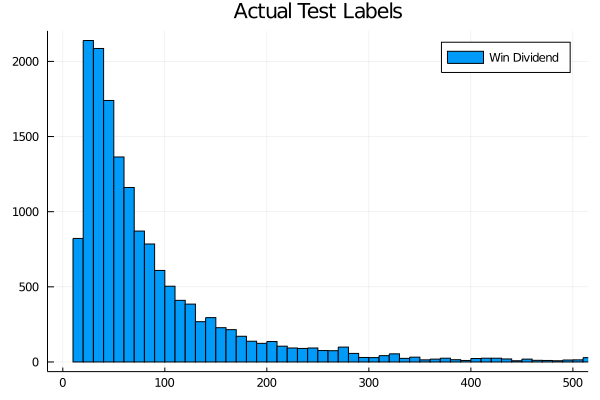

In [458]:
histogram(test_y_div, title = "Actual Test Labels", label="Win Dividend", xlims = [0,500])

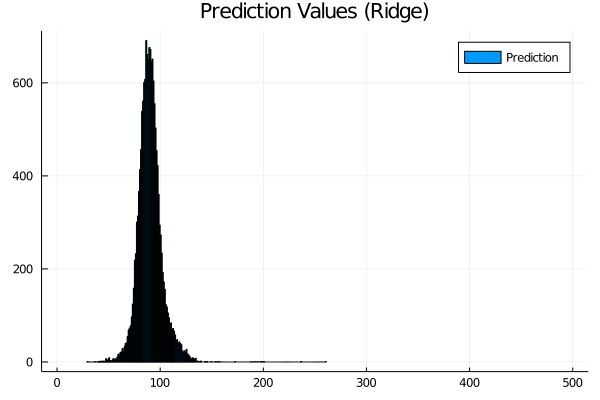

In [459]:
histogram(test_pred_ridge, title = "Prediction Values (Ridge)", label="Prediction", xlims = [0,500])

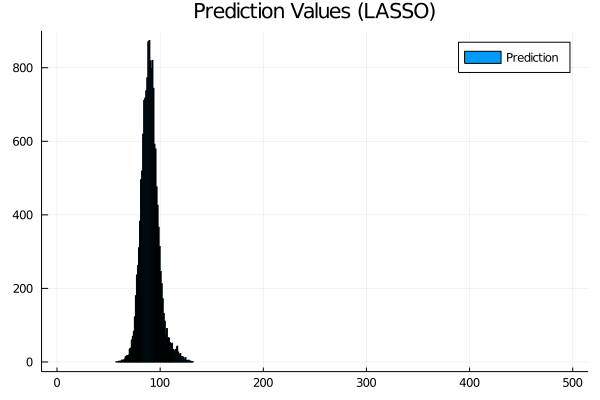

In [460]:
histogram(test_pred_lasso, title = "Prediction Values (LASSO)", label="Prediction", xlims = [0,500])

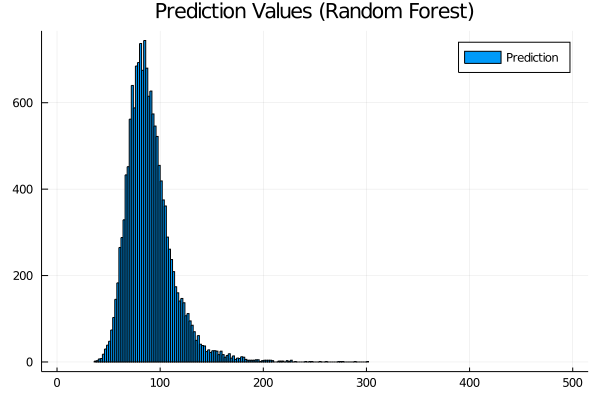

In [461]:
histogram(test_pred_rf_div, title = "Prediction Values (Random Forest)", label="Prediction", xlims = [0,500])

# Can We Profit From These Models?

In [462]:
# Simulation 1
test_exp_vals = []

ind = [x for x=1:length(test_y_div)]
ind = ind[shuffle(1:end), :]
indxs = ind[1:2000]

for i in indxs
    push!(test_exp_vals, tuple(test_pred_rf[i]*test_pred_rf_div[i], i))
end

bet_tuples = sort(test_exp_vals, rev=true)[1:100]

100-element Array{Any,1}:
 (40.29851400355963, 4753)
 (37.83919662480377, 12983)
 (37.35535484641388, 2943)
 (32.70843563579278, 13695)
 (31.984757688391127, 11964)
 (30.26062603021979, 3888)
 (29.331852686041184, 821)
 (29.126490340705374, 5250)
 (28.73239907308484, 13942)
 (28.40821064572553, 15776)
 (28.36152714517074, 14892)
 (27.623881649490283, 14747)
 (27.4530928055814, 3127)
 ⋮
 (17.023913063421, 15367)
 (17.015678146258505, 5414)
 (16.981173178673185, 14691)
 (16.924197046945558, 7305)
 (16.664345269892145, 7637)
 (16.6585230972731, 401)
 (16.656386637869772, 2481)
 (16.50964974435287, 1030)
 (16.449528946995468, 9383)
 (16.448549088771315, 4623)
 (16.315039018539515, 11866)
 (16.285945170827116, 747)

In [463]:
# win bet in our dataset costs $10 per ticket
unit_cost = 10

p = 0
for i=1:length(bet_tuples)
    p += (bet_tuples[i][1] - unit_cost)
end

println("Expected Profit: ", p)

Expected Profit: 1148.9014713338272


In [464]:
# Finding the actual profit if following our above strategy 
bet_indx = []
for i=1:length(bet_tuples)
    push!(bet_indx, bet_tuples[i][2])
end

actual_profit = 0
for index in bet_indx
    actual_profit += ((test_y_div[index]*test_y[index]) - unit_cost)
end 
println("Actual Profit: ", actual_profit)

Actual Profit: 2342.5


In [465]:
# Simulation 2
test_exp_vals = []

ind = [x for x=1:length(test_y_div)]
ind = ind[shuffle(1:end), :]
indxs = ind[1:2000]

for i in indxs
    push!(test_exp_vals, tuple(test_pred_rf[i]*test_pred_rf_div[i], i))
end

bet_tuples = sort(test_exp_vals, rev=true)[1:100]

100-element Array{Any,1}:
 (35.10712188117769, 11200)
 (33.155506013754035, 1456)
 (32.72362992680453, 9562)
 (31.49380634048491, 14073)
 (31.22104273988798, 3568)
 (30.17522309799988, 1566)
 (28.36152714517074, 14892)
 (28.070418695612144, 12452)
 (27.919873689361786, 7204)
 (27.839368244923804, 14304)
 (27.623881649490283, 14747)
 (27.162683956916116, 814)
 (26.36780020156211, 619)
 ⋮
 (17.1075718746366, 7683)
 (17.100104522792023, 9754)
 (17.064763589291367, 1493)
 (17.053782412555478, 3691)
 (17.03937472341738, 2525)
 (16.94075087335504, 7037)
 (16.86039125881834, 816)
 (16.799903571287253, 12328)
 (16.72064197530864, 7088)
 (16.635753865292553, 14154)
 (16.566318294910555, 11852)
 (16.562003245707114, 8939)

In [466]:
# win bet in our dataset costs $10 per ticket
unit_cost = 10

p = 0
for i=1:length(bet_tuples)
    p += (bet_tuples[i][1] - unit_cost)
end

println("Expected Profit: ", p)

Expected Profit: 1115.899036545548


In [467]:
# Finding the actual profit if following our above strategy 
bet_indx = []
for i=1:length(bet_tuples)
    push!(bet_indx, bet_tuples[i][2])
end

actual_profit = 0
for index in bet_indx
    actual_profit += ((test_y_div[index]*test_y[index]) - unit_cost)
end 
println("Actual Profit: ", actual_profit)

Actual Profit: 1078.0


In [468]:
# Simulation 3
test_exp_vals = []

ind = [x for x=1:length(test_y_div)]
ind = ind[shuffle(1:end), :]
indxs = ind[1:100]

for i in indxs
    push!(test_exp_vals, tuple(test_pred_rf[i]*test_pred_rf_div[i], i))
end

bet_tuples = sort(test_exp_vals, rev=true)[1:15]

15-element Array{Any,1}:
 (23.676134011949987, 12609)
 (20.895545158471748, 3222)
 (18.108085276073872, 6603)
 (16.12988382823452, 6255)
 (16.00034873101069, 15718)
 (15.953373698244729, 3482)
 (15.499554264096426, 9047)
 (15.371899495125689, 10099)
 (14.745596612630091, 6891)
 (14.704099984313524, 7964)
 (14.182967687074825, 2942)
 (13.452866385158053, 1188)
 (13.329444658442677, 4513)
 (13.155586996336995, 11024)
 (12.942571779548716, 7509)

In [469]:
# win bet in our dataset costs $10 per ticket
unit_cost = 10

p = 0
for i=1:length(bet_tuples)
    p += (bet_tuples[i][1] - unit_cost)
end

println("Expected Profit: ", p)

Expected Profit: 88.14795856671255


In [470]:
# Finding the actual profit if following our above strategy 
bet_indx = []
for i=1:length(bet_tuples)
    push!(bet_indx, bet_tuples[i][2])
end

actual_profit = 0
for index in bet_indx
    actual_profit += ((test_y_div[index]*test_y[index]) - unit_cost)
end 
println("Actual Profit: ", actual_profit)

Actual Profit: -131.0
